<a href="https://colab.research.google.com/github/hasiburrahman1/NLP/blob/master/factroid_type_(MedQuAD)_folder_(3_GHR_QA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et 
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dropout, Input, Conv2D, MaxPool2D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.optimizers import Adam
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Input, GlobalMaxPooling1D

Using TensorFlow backend.


####Convert XML into DataFrame


In [ ]:
xtree = et.parse("/content/drive/My Drive/Colab Notebooks/MedQuAD_3_GHR_QA/joined.xml")
xroot = xtree.getroot()
lst = xroot.findall('QAPairs/QAPair')
data1 = []
data2 = []
data3 = []
print(len(lst))
#print(lst)
print("\n")

for item in lst:
    for x in item:
         if x.get('qtype') != None:
            qtype = x.get('qtype')
            data1.append(qtype)
    Question = item.find('Question').text
    data2.append(Question)
    Answer = item.find('Answer').text
    data3.append(Answer)

5430




In [ ]:
df = pd.DataFrame(list(zip(data2, data3)), 
               columns =['qtype', 'Question', 'Answer']) 

#df.drop(df.columns[[2]], axis = 1, inplace = True)
print(len(df)) 
df

5430


,qtype,Question,Answer
0,information,What is (are) Aarskog-Scott syndrome ?,Aarskog-Scott syndrome is a genetic disorder t...
1,frequency,How many people are affected by Aarskog-Scott ...,Aarskog-Scott syndrome is believed to be a rar...
2,genetic changes,What are the genetic changes related to Aarsko...,Mutations in the FGD1 gene cause some cases of...
3,inheritance,Is Aarskog-Scott syndrome inherited ?,Aarskog-Scott syndrome is inherited in an X-li...
4,treatment,What are the treatments for Aarskog-Scott synd...,These resources address the diagnosis or manag...
...,...,...,...
5425,information,What is (are) 9q22.3 microdeletion ?,9q22.3 microdeletion is a chromosomal change i...
5426,frequency,How many people are affected by 9q22.3 microde...,9q22.3 microdeletion appears to be a rare chro...
5427,genetic changes,What are the genetic changes related to 9q22.3...,People with a 9q22.3 microdeletion are missing...
5428,inheritance,Is 9q22.3 microdeletion inherited ?,9q22.3 microdeletions are inherited in an auto...


###Basic data cleaning

In [ ]:
df.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

In [ ]:
df["qtype"].value_counts()

genetic changes    1086
treatment          1086
frequency          1086
information        1086
inheritance        1086
Name: qtype, dtype: int64

In [ ]:
## categorical to numerical
encode = {
    "genetic changes" : 0,
    "inheritance"  : 1,       
    "frequency" : 2,    
    "information" : 3,     
    "treatment"  : 4,    
}

In [ ]:
df["qtype"] = df["qtype"].apply(lambda x: encode[x])
df.head()

,qtype,Question,Answer
0,3,What is (are) Aarskog-Scott syndrome ?,Aarskog-Scott syndrome is a genetic disorder t...
1,2,How many people are affected by Aarskog-Scott ...,Aarskog-Scott syndrome is believed to be a rar...
2,0,What are the genetic changes related to Aarsko...,Mutations in the FGD1 gene cause some cases of...
3,1,Is Aarskog-Scott syndrome inherited ?,Aarskog-Scott syndrome is inherited in an X-li...
4,4,What are the treatments for Aarskog-Scott synd...,These resources address the diagnosis or manag...


###Data cleaning for NLP

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [ ]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    ques_lines = list()
    lines = df["Question"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        
        ques_lines.append(words)
        
    return ques_lines

ques_lines = CleanTokenize(df)
print("total line are ", len(ques_lines)) 
ques_lines[0:10]

total line are  5430


[['aarskogscott', 'syndrome'],
 ['many', 'people', 'affected', 'aarskogscott', 'syndrome'],
 ['genetic', 'changes', 'related', 'aarskogscott', 'syndrome'],
 ['aarskogscott', 'syndrome', 'inherited'],
 ['treatments', 'aarskogscott', 'syndrome'],
 ['abdominal', 'wall', 'defect'],
 ['many', 'people', 'affected', 'abdominal', 'wall', 'defect'],
 ['genetic', 'changes', 'related', 'abdominal', 'wall', 'defect'],
 ['abdominal', 'wall', 'defect', 'inherited'],
 ['treatments', 'abdominal', 'wall', 'defect']]

In [ ]:
len(max(ques_lines, key=len))

13

###Train-test split

In [ ]:
validation_split = 0.2
max_length = 15


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(ques_lines)
sequences = tokenizer_obj.texts_to_sequences(ques_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

ques_lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
qtype =  df['qtype'].values

indices = np.arange(ques_lines_pad.shape[0])
np.random.shuffle(indices)
ques_lines_pad = ques_lines_pad[indices]
qtype = qtype[indices]

n_values = np.max(qtype) + 1

Y = np.eye(n_values)[qtype]


num_validation_samples = int(validation_split * ques_lines_pad.shape[0])

X_train_pad = ques_lines_pad[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
X_test_pad = ques_lines_pad[-num_validation_samples:]
y_test = Y[-num_validation_samples:]

unique tokens -  1419
vocab size - 1420


In [ ]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (4344, 15)
Shape of y_train: (4344, 5)
Shape of X_test_pad: (1086, 15)
Shape of y_test: (1086, 5)


###Custom word2vec model

In [ ]:
import gensim
model = gensim.models.Word2Vec(sentences=ques_lines, size=100, window=5, workers=4, min_count=1, sg=1) #sg= 1:skip-gram 0:cbow
vocab_words = list(model.wv.vocab)   

print(len(vocab_words))
print(vocab_words)

1419
['aarskogscott', 'syndrome', 'many', 'people', 'affected', 'genetic', 'changes', 'related', 'inherited', 'treatments', 'abdominal', 'wall', 'defect', 'abetalipoproteinemia', 'acatalasemia', 'aceruloplasminemia', 'achondrogenesis', 'achondroplasia', 'achromatopsia', 'acral', 'peeling', 'skin', 'acromicric', 'dysplasia', 'actinaccumulation', 'myopathy', 'activated', 'acute', 'promyelocytic', 'leukemia', 'adamsoliver', 'dyskinesia', 'adenine', 'phosphoribosyltransferase', 'deficiency', 'adenosine', 'deaminase', 'monophosphate', 'adenylosuccinate', 'lyase', 'adermatoglyphia', 'adiposis', 'dolorosa', 'adolescent', 'idiopathic', 'scoliosis', 'adult', 'polyglucosan', 'body', 'disease', 'adultonset', 'leukoencephalopathy', 'axonal', 'spheroids', 'pigmented', 'glia', 'african', 'iron', 'overload', 'agerelated', 'macular', 'degeneration', 'aicardi', 'aicardigoutieres', 'alagille', 'alexander', 'disorder', 'glycosylation', 'alkaptonuria', 'allanherndondudley', 'allergic', 'asthma', 'alpershu

In [ ]:
filename = "questype_word2vec_full.txt"
model.wv.save_word2vec_format(filename, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
embedding_index = {}
f = open(os.path.join('', '/content/questype_word2vec_full.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1420, 100)

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

##Create LSTM model

In [ ]:
'''
model1 = Sequential()
model1.add(embedding_layer)
model1.add(LSTM(100, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(100, return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(5, activation = "softmax"))
'''
'''
# define model
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(5, activation='softmax'))
'''
'''
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model1.summary())
'''

"\nmodel1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nprint(model1.summary())\n"

In [ ]:

model1 = Sequential()
model1.add(embedding_layer)
# Recurrent layer
model1.add(LSTM(100, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model1.add(Dense(100, activation='relu'))

# Dropout for regularization
model1.add(Dropout(0.5))

# Output layer
model1.add(Dense(5, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model1.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           142000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 233,005
Trainable params: 91,005
Non-trainable params: 142,000
_________________________________________________________________
None



###LSTM Model Training

In [ ]:
history = model1.fit(X_train_pad, y_train, epochs=10,batch_size=32, validation_data=(X_test_pad, y_test), verbose=1)

Train on 4344 samples, validate on 1086 samples
Epoch 1/10
4344/4344 [==============================] - 9s 2ms/step - loss: 1.3975 - accuracy: 0.3768 - val_loss: 1.1645 - val_accuracy: 0.6473
Epoch 2/10
4344/4344 [==============================] - 7s 2ms/step - loss: 0.7589 - accuracy: 0.6697 - val_loss: 0.5373 - val_accuracy: 0.6952
Epoch 3/10
4344/4344 [==============================] - 7s 2ms/step - loss: 0.5251 - accuracy: 0.7548 - val_loss: 0.3769 - val_accuracy: 0.8554
Epoch 4/10
4344/4344 [==============================] - 7s 2ms/step - loss: 0.3946 - accuracy: 0.8386 - val_loss: 0.3796 - val_accuracy: 0.8241
Epoch 5/10
4344/4344 [==============================] - 7s 2ms/step - loss: 0.3227 - accuracy: 0.8752 - val_loss: 0.2175 - val_accuracy: 0.9061
Epoch 6/10
4344/4344 [==============================] - 7s 2ms/step - loss: 0.2917 - accuracy: 0.8980 - val_loss: 0.2144 - val_accuracy: 0.9180
Epoch 7/10
4344/4344 [==============================] - 7s 2ms/step - loss: 0.2320 - acc

In [ ]:

print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])


[1.3975482612683627, 0.7589389800366776, 0.5251119424679881, 0.394634994518691, 0.3227360642911321, 0.2917353464753588, 0.232043638002148, 0.1837551532172586, 0.18753718246549753, 0.1604781789125439]
[0.37684163, 0.6696593, 0.75483423, 0.838628, 0.8752302, 0.89802027, 0.9201197, 0.9371547, 0.9380755, 0.9479742]
[1.164542151858574, 0.5373368956985615, 0.3768554534042738, 0.3795915200730055, 0.21747842550442364, 0.21443168895789053, 0.14274651707453623, 0.1469984272937419, 0.12310886992275386, 0.0965975052977245]
[0.6473296284675598, 0.6952117681503296, 0.8554328083992004, 0.8241252303123474, 0.9060773253440857, 0.9180479049682617, 0.9429097771644592, 0.9355432987213135, 0.9539594650268555, 0.968692421913147]


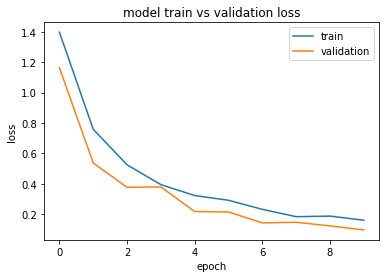

In [ ]:

from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()


####Bidirectional LSTM

In [ ]:

model2 =Sequential()
model2.add(embedding_layer)

model2.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.25)))
model2.add(Dense(5, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model2.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           142000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1005      
Total params: 303,805
Trainable params: 161,805
Non-trainable params: 142,000
_________________________________________________________________
None


In [ ]:
history = model2.fit(X_train_pad, y_train, epochs=10,batch_size=32, validation_data=(X_test_pad, y_test), verbose=1)

Train on 4344 samples, validate on 1086 samples
Epoch 1/10
4344/4344 [==============================] - 14s 3ms/step - loss: 1.0103 - accuracy: 0.6441 - val_loss: 0.4827 - val_accuracy: 0.8425
Epoch 2/10
4344/4344 [==============================] - 14s 3ms/step - loss: 0.3652 - accuracy: 0.8768 - val_loss: 0.2625 - val_accuracy: 0.8840
Epoch 3/10
4344/4344 [==============================] - 14s 3ms/step - loss: 0.2673 - accuracy: 0.9022 - val_loss: 0.1863 - val_accuracy: 0.9162
Epoch 4/10
4344/4344 [==============================] - 13s 3ms/step - loss: 0.1898 - accuracy: 0.9296 - val_loss: 0.1260 - val_accuracy: 0.9595
Epoch 5/10
4344/4344 [==============================] - 13s 3ms/step - loss: 0.1620 - accuracy: 0.9434 - val_loss: 0.1115 - val_accuracy: 0.9595
Epoch 6/10
4344/4344 [==============================] - 14s 3ms/step - loss: 0.1363 - accuracy: 0.9542 - val_loss: 0.0859 - val_accuracy: 0.9779
Epoch 7/10
4344/4344 [==============================] - 13s 3ms/step - loss: 0.118

###GRU

In [ ]:

#https://www.programcreek.com/python/example/97114/keras.layers.recurrent.GRU

model3 = Sequential()
model3.add(embedding_layer)
model3.add(Dropout(0.5))
model3.add(GRU(100, return_sequences=False))
# Add dropout if overfitting
model3.add(Dropout(0.5))
model3.add(Dense(5))
model3.add(Activation('softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           142000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 202,805
Trainable params: 60,805
Non-trainable params: 142,000
___________________________________________

In [ ]:
history = model3.fit(X_train_pad, y_train, epochs=10,batch_size=60, validation_data=(X_test_pad, y_test), verbose=1)

Train on 4344 samples, validate on 1086 samples
Epoch 1/10
4344/4344 [==============================] - 5s 1ms/step - loss: 1.5118 - accuracy: 0.3135 - val_loss: 1.3562 - val_accuracy: 0.4024
Epoch 2/10
4344/4344 [==============================] - 5s 1ms/step - loss: 1.2861 - accuracy: 0.4201 - val_loss: 1.1900 - val_accuracy: 0.4420
Epoch 3/10
4344/4344 [==============================] - 5s 1ms/step - loss: 1.0644 - accuracy: 0.5147 - val_loss: 0.8708 - val_accuracy: 0.5912
Epoch 4/10
4344/4344 [==============================] - 5s 1ms/step - loss: 0.7694 - accuracy: 0.6733 - val_loss: 0.5696 - val_accuracy: 0.8002
Epoch 5/10
4344/4344 [==============================] - 5s 1ms/step - loss: 0.5358 - accuracy: 0.7776 - val_loss: 0.3870 - val_accuracy: 0.7661
Epoch 6/10
4344/4344 [==============================] - 5s 1ms/step - loss: 0.4487 - accuracy: 0.8029 - val_loss: 0.3828 - val_accuracy: 0.7698
Epoch 7/10
4344/4344 [==============================] - 5s 1ms/step - loss: 0.4051 - acc

###Simple RNN

In [ ]:

#https://medium.com/@hemantranvir/spam-detection-using-rnn-simplernn-lstm-with-step-by-step-explanation-530367608071
model4 = Sequential()
model4.add(embedding_layer)
#model.add(SimpleRNN(units=embedding_mat_columns))
model4.add(SimpleRNN(units=100, dropout=0.2, recurrent_dropout=0.25))
model4.add(Dense(5, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           142000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 505       
Total params: 162,605
Trainable params: 20,605
Non-trainable params: 142,000
_________________________________________________________________


In [ ]:
history = model4.fit(X_train_pad, y_train, epochs=10,batch_size=60, validation_data=(X_test_pad, y_test), verbose=1)

Train on 4344 samples, validate on 1086 samples
Epoch 1/10
4344/4344 [==============================] - 2s 472us/step - loss: 1.4982 - accuracy: 0.3416 - val_loss: 1.0588 - val_accuracy: 0.7007
Epoch 2/10
4344/4344 [==============================] - 2s 425us/step - loss: 1.1763 - accuracy: 0.5564 - val_loss: 0.6760 - val_accuracy: 0.8324
Epoch 3/10
4344/4344 [==============================] - 2s 416us/step - loss: 0.7587 - accuracy: 0.7408 - val_loss: 0.3777 - val_accuracy: 0.8600
Epoch 4/10
4344/4344 [==============================] - 2s 432us/step - loss: 0.5516 - accuracy: 0.7901 - val_loss: 0.3094 - val_accuracy: 0.8674
Epoch 5/10
4344/4344 [==============================] - 2s 421us/step - loss: 0.4975 - accuracy: 0.8131 - val_loss: 0.2469 - val_accuracy: 0.8987
Epoch 6/10
4344/4344 [==============================] - 2s 415us/step - loss: 0.4191 - accuracy: 0.8377 - val_loss: 0.2622 - val_accuracy: 0.8738
Epoch 7/10
4344/4344 [==============================] - 2s 422us/step - loss

####CNN

In [ ]:
#https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py----------
#https://github.com/bhaveshoswal/CNN-text-classification-keras/blob/master/model.py
# set parameters:
filters = 250
kernel_size = 3
hidden_dims = 100

model5 = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions

#model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model5.add(embedding_layer)
model5.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model5.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model5.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model5.add(Dense(hidden_dims))
model5.add(Dropout(0.2))
model5.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model5.add(Dense(5))
model5.add(Activation('softmax'))

model5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           142000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 250)           75250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               25100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 100)              

In [ ]:
history = model5.fit(X_train_pad, y_train, epochs=10,batch_size=60, validation_data=(X_test_pad, y_test), verbose=1)

Train on 4344 samples, validate on 1086 samples
Epoch 1/10
4344/4344 [==============================] - 5s 1ms/step - loss: 1.0904 - accuracy: 0.6575 - val_loss: 0.5463 - val_accuracy: 0.8315
Epoch 2/10
4344/4344 [==============================] - 0s 110us/step - loss: 0.4342 - accuracy: 0.8616 - val_loss: 0.2970 - val_accuracy: 0.8775
Epoch 3/10
4344/4344 [==============================] - 0s 113us/step - loss: 0.2836 - accuracy: 0.9017 - val_loss: 0.1931 - val_accuracy: 0.9245
Epoch 4/10
4344/4344 [==============================] - 0s 108us/step - loss: 0.2181 - accuracy: 0.9243 - val_loss: 0.1459 - val_accuracy: 0.9392
Epoch 5/10
4344/4344 [==============================] - 0s 110us/step - loss: 0.1580 - accuracy: 0.9482 - val_loss: 0.1116 - val_accuracy: 0.9659
Epoch 6/10
4344/4344 [==============================] - 0s 113us/step - loss: 0.1470 - accuracy: 0.9519 - val_loss: 0.1126 - val_accuracy: 0.9641
Epoch 7/10
4344/4344 [==============================] - 0s 108us/step - loss: 


###Can this model detect qtype?



In [ ]:
from pandas import *
import operator
def predict_(s):
    x_final = pd.DataFrame({"Question":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model1.predict(test_review_pad)
    #print(f'NumPy Array:\n{[pred]}')
    pred = pred.ravel()
    listOfInt  = pred.tolist()
    #print(listOfInt)
    listOfStr = ["genetic changes", "inheritance", "frequency" , "information" , "treatment"]
    # Create a zip object from two lists
    zipbObj = zip(listOfStr, listOfInt)
    # Create a dictionary from zip object
    dictOfresult = dict(zipbObj)
    #print(dictOfresult)
    print(s, end =" ")
    print( max(dictOfresult.items(), key=operator.itemgetter(1))[0])

In [ ]:
predict_("What is (are) Coronavirous syndrome ?")    

What is (are) Coronavirous syndrome ? information


In [ ]:
predict_("How many people are affected by Coronavirous syndrome ?")

How many people are affected by Coronavirous syndrome ? frequency


In [ ]:
predict_("Is Coronavirous inherited ?")

Is Coronavirous inherited ? treatment
